### Sync timing on the Chameleon 3 cameras with PCO and NIDAQ load

This test was performed the following system:
 - Intel(R) Core(TM) i5-9600K CPU @ 3.70GHz
 - 32 Gb memory
 - GeForce GTX 1030 (not used, encoding using the CPU)
 - Windows

Running **1 CM3 cameras at 30 Hz with 5ms exposure time**; running a **NI USB-6361** at 10kHz sampling 2 analog channels and a **PCO edge 5.5**. 
An LED is connected to a TTL and placed in front of the cameras and plugged to **line2**, the TTL flashes for **500ms**.

The ``default.json`` file is:

```json
{
    "cams": [
	{
            "cam_id": 0, 
            "name": "sync", 
            "driver": "nidaq", 
            "srate": 10000,
	    "device":"dev4",
	    "digital":{},
	    "analog": {
		"ai0":"trial",
		"ai1":"led470nm"
	    },
	    "recorder": {"format":"binary",
			 "pathformat":"{recorder_path}\\{foldername}\\{dataname}\\{basename}_{run}_{nfiles}.{dataname}"}
	},
	{
            "driver": "pco", 
            "exposure": 100, 
            "cam_id": 1, 
            "name": "one_photon", 
            "trigger_type": 0,
	    "binning": 4,
	    "recorder": {"format":"binary",
			 "frames_per_file": 0}
        },
{
            "Save": true,
            "driver": "PointGrey",
            "frame_rate": 30.0,
            "gain": 1,
	    "exposure":5000,
	    "gamma":2.3,
	    "pxformat":"Mono8",
	    "cam_id": 2,
	    "serial":21105772,
            "name": "cam0",
	    "recorder":{
		"format":"ffmpeg",
		"compression": "17"		
	    },
	    "hardware_trigger":"out_line2",
	    "roi": [100,100,752,752]
        }
    ],
    "recorder_path": "D:\\data",
    "recorder_path_format":"{recorder_path}\\{filename}_{dataname}_{run}_{nfiles}",
    "server":"udp",
    "server_port": 9998
}
```

This notebook processes the camlog to extract the sync frames and plots the onset and offset triggered camera data.

In [34]:
%matplotlib notebook
from labcams import parse_cam_log,unpackbits
from pathlib import Path
import cv2
import pylab as plt
import numpy as np

In [33]:
logfile = Path('D:/data/dummy/20250415_183120/one_photon/dummy_20250415_183120_cam0_run000_00000000.camlog')
log,coms = parse_cam_log(str(logfile)) # read the log
ons,offs = unpackbits(log.var2) # unpack the log bits

In [35]:
print(f'The frame rate is {1./np.diff(log.timestamp.values).mean()}')
# read the video and compute the average of each frame
cap = cv2.VideoCapture(str(logfile.with_suffix('.avi')))
avg = []
while(cap.isOpened()):
    ret, frame = cap.read()
    if not frame is None:
        avg.append((frame[:,:,0].mean()))
    else:
        break
cap.release()
avg = np.array(avg)

The frame rate is 30.02213090459264


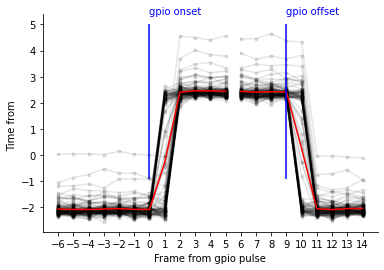

In [37]:
# trigger the camera frame average on the gpio pulses 
plt.figure()
ii = np.arange(len(avg))
aa = []
bb = []
idx = np.arange(-6,6)
idxpost = np.arange(-3,6)
for o,f in zip(ons[3],offs[3]):
    i = np.where(ii==o)[0][-1]
    pre = avg[:i].mean()
    aa.append(avg[i+idx]-pre)
    i = np.where(ii==f)[0][-1]
    
    bb.append(avg[i+idxpost]-pre)
plt.plot(idx,np.stack(aa).T,'.k-',alpha = 0.1);
plt.plot(idx,np.stack(aa).mean(axis = 0),'r-',alpha = 1);

plt.plot(idxpost+9,np.stack(bb).T,'.k-',alpha = 0.1);
plt.plot(idxpost+9,np.stack(bb).mean(axis = 0),'r-',alpha = 1);
plt.vlines([0,9],plt.ylim()[0]+2,plt.ylim()[-1],color = 'b')
plt.xticks(np.arange(idx[0],9+idxpost[-1]+1));
plt.text(0,plt.ylim()[-1], 'gpio onset',color = 'b')
plt.text(9,plt.ylim()[-1], 'gpio offset',color = 'b')
plt.ylabel('Frame brightness')
plt.ylabel('Time from ')
ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
plt.xlabel('Frame from gpio pulse');
# plt.savefig('cam0_90Hz_sync_led.pdf')